# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator, Full_Diff_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
def Plank(x):
    return(1/(np.exp(1/x) -1 ))

Klist0 = [] #[ FKernel(Log, ['q'], 1), FKernel(Plank, ['t'], 250)]
Klist = []
#Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['pl', 'rl', 'ri','ts'])]

fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0)
normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)

#D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D2 = [DictPrepross(['o3','pl','q'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
#D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
#D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

del(normal_generator)
del(fit_genator)

##### Full Preprocessing :
#FP = Klist0 + D + Klist + D2  + D3 + V 
FP = Klist0 + D + Klist + D2  +  V 

##### b_size
batch_size= 64


train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = Full_Diff_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

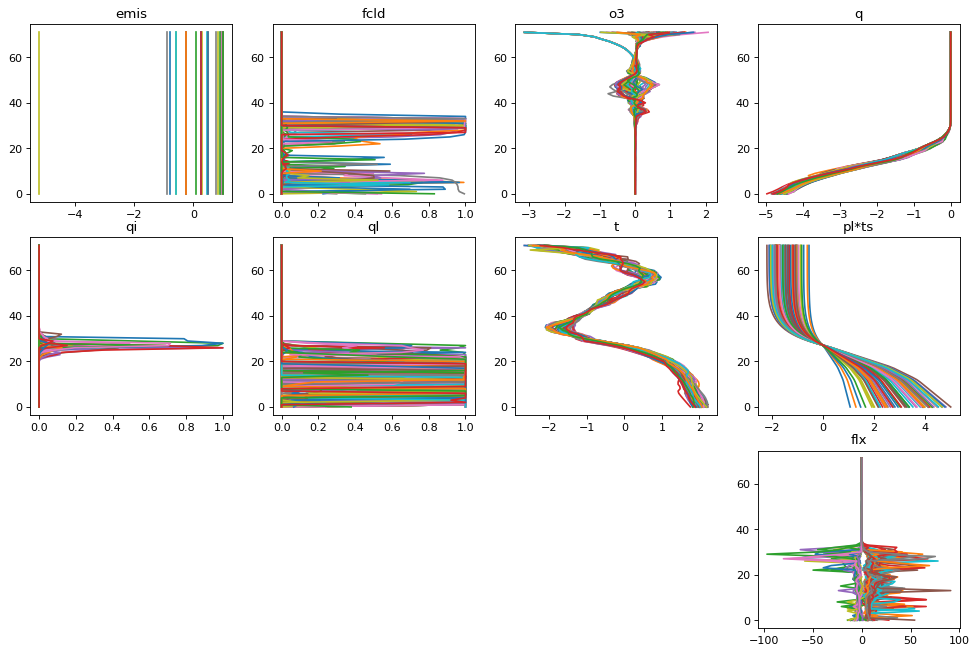

In [3]:
x,y = train_generator[0]
Plot_Batch(x,y,header_x)

### Model construct

In [4]:
from architectures import AE, Unet_Act_Double
import keras
from architectures_simples import Upsampler
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
from architectures_utils import Activation_Generator
import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime


list_of_filters_bdc =  [[64, 100, 32], [32, 20, 10], [100]]
list_of_kernel_bdc =  [[12, 5, 5], [10, 5, 3], [5, 3]]
list_of_activation_bdc =  [['elu', 'elu', 'elu'], ['elu', 'elu', 'elu'], ['relu']]


list_of_filters_ae =  [[64, 128, 128], [50, 50, 75, 75, 100, 100], [20, 20], [50, 50, 100, 100, 200, 200], [300, 2]]
list_of_kernel_ae =  [[10, 10, 5], [2, 5, 2, 5, 2, 4], [], [2, 4, 2, 5, 2, 6], [5, 3]]
list_of_activations_ae =  [['elu', 'elu', 'elu'], ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], ['sigmoid', 'sigmoid'], ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], ['elu', 'linear']]
params_ae = [0.1]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_bd =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)


M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M_unet.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:29: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `Av

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 8)        0                                            
__________________________________________________________________________________________________
Conv_0 (Conv1D)                 (None, 72, 64)       5120        Origin_Input[0][0]               
__________________________________________________________________________________________________
elu_0 (ELU)                     (None, 72, 64)       0           Conv_0[0][0]                     
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 72, 128)      81920       elu_0[0][0]                      
__________________________________________________________________________________________________
elu_1 (ELU

In [7]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

def Up_Down_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    return E

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = '20190604155532U_d'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['flxu_loss', 'flxd_loss', 'loss'])
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=Up_Down_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 8)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 2)             1179595   
Total params: 1,179,595
Trainable params: 1,179,595
Non-trainable params: 0
_________________________________________________________________


In [10]:
M.load_weights('TrainedModels/'+ prefix)

In [11]:
from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, y in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(y0)
    MSE = np.array(MSE)
    return(MSE)

train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
V = Plot_Earth(M, train_generator, 5)
V=np.array(V)
np.save('pred_'+prefix,V)

100%|██████████| 25/25 [13:37<00:00, 32.64s/it]
